# HAR CNN training 

In [4]:
# %load utils/utilities.py
# HAR classification 
# Author: Burak Himmetoglu
# 8/15/2017

import pandas as pd 
import numpy as np
import os

def read_data(data_path, split = "train"):
	""" Read data """

	# Fixed params
	n_class = 6
	n_steps = 128

	# Paths
	path_ = os.path.join(data_path, split)
	path_signals = os.path.join(path_, "Inertial_Signals")

	# Read labels and one-hot encode
	label_path = os.path.join(path_, "y_" + split + ".txt")
	labels = pd.read_csv(label_path, header = None)

	# Read time-series data
	channel_files = os.listdir(path_signals)
	channel_files.sort()
	n_channels = len(channel_files)
	posix = len(split) + 5

	# Initiate array
	list_of_channels = []
	X = np.zeros((len(labels), n_steps, n_channels))
	i_ch = 0
	for fil_ch in channel_files:
		channel_name = fil_ch[:-posix]
		dat_ = pd.read_csv(os.path.join(path_signals,fil_ch), delim_whitespace = True, header = None)
		X[:,:,i_ch] = dat_.as_matrix()

		# Record names
		list_of_channels.append(channel_name)

		# iterate
		i_ch += 1

	# Return 
	return X, labels[0].values, list_of_channels

def standardize(train, test):
	""" Standardize data """

	# Standardize train and test
	X_train = (train - np.mean(train, axis=0)[None,:,:]) / np.std(train, axis=0)[None,:,:]
	X_test = (test - np.mean(test, axis=0)[None,:,:]) / np.std(test, axis=0)[None,:,:]

	return X_train, X_test

def one_hot(labels, n_class = 6):
	""" One-hot encoding """
	expansion = np.eye(n_class)
	y = expansion[:, labels-1].T
	assert y.shape[1] == n_class, "Wrong number of labels!"

	return y

def get_batches(X, y, batch_size = 100):
	""" Return a generator for batches """
	n_batches = len(X) // batch_size
	X, y = X[:n_batches*batch_size], y[:n_batches*batch_size]

	# Loop over batches and yield
	for b in range(0, len(X), batch_size):
		yield X[b:b+batch_size], y[b:b+batch_size]
	






## Prepare data

In [5]:
rootDatasetDir = "./datasets/"
X_train, labels_train, list_ch_train = read_data(data_path=rootDatasetDir, split="train") # train
X_test, labels_test, list_ch_test = read_data(data_path=rootDatasetDir, split="test") # test

assert list_ch_train == list_ch_test, "Mistmatch in channels!"

In [6]:
# Normalize?
X_train, X_test = standardize(X_train, X_test)

Train/Validation Split

In [7]:
X_tr, X_vld, lab_tr, lab_vld = train_test_split(X_train, labels_train, 
                                                stratify = labels_train, random_state = 123)

One-hot encoding:

In [8]:
y_tr = one_hot(lab_tr)
y_vld = one_hot(lab_vld)
y_test = one_hot(labels_test)

In [9]:
# Imports
import tensorflow as tf

### Hyperparameters

In [10]:
batch_size = 600       # Batch size
seq_len = 128          # Number of steps
learning_rate = 0.0001
epochs = 1000

n_classes = 6
n_channels = 9

### Construct the graph
Placeholders

In [11]:
graph = tf.Graph()

# Construct placeholders
with graph.as_default():
    inputs_ = tf.placeholder(tf.float32, [None, seq_len, n_channels], name = 'inputs')
    labels_ = tf.placeholder(tf.float32, [None, n_classes], name = 'labels')
    keep_prob_ = tf.placeholder(tf.float32, name = 'keep')
    learning_rate_ = tf.placeholder(tf.float32, name = 'learning_rate')

Build Convolutional Layers

Note: Should we use a different activation? Like tf.nn.tanh?

In [12]:
with graph.as_default():
    # (batch, 128, 9) --> (batch, 64, 18)
    conv1 = tf.layers.conv1d(inputs=inputs_, filters=18, kernel_size=2, strides=1, 
                             padding='same', activation = tf.nn.relu)
    max_pool_1 = tf.layers.max_pooling1d(inputs=conv1, pool_size=2, strides=2, padding='same')
    
    # (batch, 64, 18) --> (batch, 32, 36)
    conv2 = tf.layers.conv1d(inputs=max_pool_1, filters=36, kernel_size=2, strides=1, 
                             padding='same', activation = tf.nn.relu)
    max_pool_2 = tf.layers.max_pooling1d(inputs=conv2, pool_size=2, strides=2, padding='same')
    
    # (batch, 32, 36) --> (batch, 16, 72)
    conv3 = tf.layers.conv1d(inputs=max_pool_2, filters=72, kernel_size=2, strides=1, 
                             padding='same', activation = tf.nn.relu)
    max_pool_3 = tf.layers.max_pooling1d(inputs=conv3, pool_size=2, strides=2, padding='same')
    
    # (batch, 16, 72) --> (batch, 8, 144)
    conv4 = tf.layers.conv1d(inputs=max_pool_3, filters=144, kernel_size=2, strides=1, 
                             padding='same', activation = tf.nn.relu)
    max_pool_4 = tf.layers.max_pooling1d(inputs=conv4, pool_size=2, strides=2, padding='same')

Now, flatten and pass to the classifier

In [13]:
with graph.as_default():
    # Flatten and add dropout
    flat = tf.reshape(max_pool_4, (-1, 8*144))
    flat = tf.nn.dropout(flat, keep_prob=keep_prob_)
    
    # Predictions
    logits = tf.layers.dense(flat, n_classes)
    
    # Cost function and optimizer
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels_))
    optimizer = tf.train.AdamOptimizer(learning_rate_).minimize(cost)
    
    # Accuracy
    correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(labels_, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

### Train the network

In [14]:
if (os.path.exists('checkpoints-cnn') == False):
    !mkdir checkpoints-cnn

In [15]:
validation_acc = []
validation_loss = []

train_acc = []
train_loss = []

with graph.as_default():
    saver = tf.train.Saver()

with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    iteration = 1
   
    # Loop over epochs
    for e in range(epochs):
        
        # Loop over batches
        for x,y in get_batches(X_tr, y_tr, batch_size):
            
            # Feed dictionary
            feed = {inputs_ : x, labels_ : y, keep_prob_ : 0.5, learning_rate_ : learning_rate}
            
            # Loss
            loss, _ , acc = sess.run([cost, optimizer, accuracy], feed_dict = feed)
            train_acc.append(acc)
            train_loss.append(loss)
            
            # Print at each 5 iters
            if (iteration % 5 == 0):
                print("Epoch: {}/{}".format(e, epochs),
                      "Iteration: {:d}".format(iteration),
                      "Train loss: {:6f}".format(loss),
                      "Train acc: {:.6f}".format(acc))
            
            # Compute validation loss at every 10 iterations
            if (iteration%10 == 0):                
                val_acc_ = []
                val_loss_ = []
                
                for x_v, y_v in get_batches(X_vld, y_vld, batch_size):
                    # Feed
                    feed = {inputs_ : x_v, labels_ : y_v, keep_prob_ : 1.0}  
                    
                    # Loss
                    loss_v, acc_v = sess.run([cost, accuracy], feed_dict = feed)                    
                    val_acc_.append(acc_v)
                    val_loss_.append(loss_v)
                
                # Print info
                print("Epoch: {}/{}".format(e, epochs),
                      "Iteration: {:d}".format(iteration),
                      "Validation loss: {:6f}".format(np.mean(val_loss_)),
                      "Validation acc: {:.6f}".format(np.mean(val_acc_)))
                
                # Store
                validation_acc.append(np.mean(val_acc_))
                validation_loss.append(np.mean(val_loss_))
            
            # Iterate 
            iteration += 1
    
    saver.save(sess,"checkpoints-cnn/har.ckpt")

Epoch: 0/1000 Iteration: 5 Train loss: 1.825077 Train acc: 0.215000
Epoch: 1/1000 Iteration: 10 Train loss: 1.772171 Train acc: 0.225000
Epoch: 1/1000 Iteration: 10 Validation loss: 1.737075 Validation acc: 0.319444
Epoch: 1/1000 Iteration: 15 Train loss: 1.743696 Train acc: 0.218333
Epoch: 2/1000 Iteration: 20 Train loss: 1.660818 Train acc: 0.286667
Epoch: 2/1000 Iteration: 20 Validation loss: 1.646207 Validation acc: 0.333333
Epoch: 2/1000 Iteration: 25 Train loss: 1.643298 Train acc: 0.286667
Epoch: 3/1000 Iteration: 30 Train loss: 1.604820 Train acc: 0.311667
Epoch: 3/1000 Iteration: 30 Validation loss: 1.574254 Validation acc: 0.347778
Epoch: 3/1000 Iteration: 35 Train loss: 1.567022 Train acc: 0.323333
Epoch: 4/1000 Iteration: 40 Train loss: 1.541586 Train acc: 0.341667
Epoch: 4/1000 Iteration: 40 Validation loss: 1.509493 Validation acc: 0.370000
Epoch: 4/1000 Iteration: 45 Train loss: 1.535701 Train acc: 0.306667
Epoch: 5/1000 Iteration: 50 Train loss: 1.469185 Train acc: 0.38

Epoch: 41/1000 Iteration: 375 Train loss: 0.184913 Train acc: 0.931667
Epoch: 42/1000 Iteration: 380 Train loss: 0.195981 Train acc: 0.933333
Epoch: 42/1000 Iteration: 380 Validation loss: 0.181016 Validation acc: 0.926667
Epoch: 42/1000 Iteration: 385 Train loss: 0.206990 Train acc: 0.930000
Epoch: 43/1000 Iteration: 390 Train loss: 0.219514 Train acc: 0.915000
Epoch: 43/1000 Iteration: 390 Validation loss: 0.175882 Validation acc: 0.928889
Epoch: 43/1000 Iteration: 395 Train loss: 0.173302 Train acc: 0.938333
Epoch: 44/1000 Iteration: 400 Train loss: 0.203210 Train acc: 0.915000
Epoch: 44/1000 Iteration: 400 Validation loss: 0.171312 Validation acc: 0.927222
Epoch: 44/1000 Iteration: 405 Train loss: 0.194218 Train acc: 0.925000
Epoch: 45/1000 Iteration: 410 Train loss: 0.188121 Train acc: 0.926667
Epoch: 45/1000 Iteration: 410 Validation loss: 0.167170 Validation acc: 0.927222
Epoch: 46/1000 Iteration: 415 Train loss: 0.179972 Train acc: 0.936667
Epoch: 46/1000 Iteration: 420 Train l

Epoch: 82/1000 Iteration: 745 Train loss: 0.135055 Train acc: 0.941667
Epoch: 83/1000 Iteration: 750 Train loss: 0.153511 Train acc: 0.933333
Epoch: 83/1000 Iteration: 750 Validation loss: 0.121037 Validation acc: 0.948889
Epoch: 83/1000 Iteration: 755 Train loss: 0.107568 Train acc: 0.951667
Epoch: 84/1000 Iteration: 760 Train loss: 0.142403 Train acc: 0.935000
Epoch: 84/1000 Iteration: 760 Validation loss: 0.120560 Validation acc: 0.949444
Epoch: 84/1000 Iteration: 765 Train loss: 0.128815 Train acc: 0.953333
Epoch: 85/1000 Iteration: 770 Train loss: 0.136058 Train acc: 0.945000
Epoch: 85/1000 Iteration: 770 Validation loss: 0.120179 Validation acc: 0.948889
Epoch: 86/1000 Iteration: 775 Train loss: 0.120891 Train acc: 0.941667
Epoch: 86/1000 Iteration: 780 Train loss: 0.120985 Train acc: 0.946667
Epoch: 86/1000 Iteration: 780 Validation loss: 0.119683 Validation acc: 0.950000
Epoch: 87/1000 Iteration: 785 Train loss: 0.119565 Train acc: 0.958333
Epoch: 87/1000 Iteration: 790 Train l

Epoch: 123/1000 Iteration: 1110 Train loss: 0.129765 Train acc: 0.940000
Epoch: 123/1000 Iteration: 1110 Validation loss: 0.108729 Validation acc: 0.955555
Epoch: 123/1000 Iteration: 1115 Train loss: 0.083267 Train acc: 0.966667
Epoch: 124/1000 Iteration: 1120 Train loss: 0.122385 Train acc: 0.941667
Epoch: 124/1000 Iteration: 1120 Validation loss: 0.108522 Validation acc: 0.957222
Epoch: 124/1000 Iteration: 1125 Train loss: 0.119457 Train acc: 0.955000
Epoch: 125/1000 Iteration: 1130 Train loss: 0.108140 Train acc: 0.958333
Epoch: 125/1000 Iteration: 1130 Validation loss: 0.108446 Validation acc: 0.957222
Epoch: 126/1000 Iteration: 1135 Train loss: 0.105908 Train acc: 0.956667
Epoch: 126/1000 Iteration: 1140 Train loss: 0.102896 Train acc: 0.948333
Epoch: 126/1000 Iteration: 1140 Validation loss: 0.108305 Validation acc: 0.955000
Epoch: 127/1000 Iteration: 1145 Train loss: 0.105715 Train acc: 0.965000
Epoch: 127/1000 Iteration: 1150 Train loss: 0.120399 Train acc: 0.946667
Epoch: 127/

Epoch: 163/1000 Iteration: 1470 Train loss: 0.119029 Train acc: 0.935000
Epoch: 163/1000 Iteration: 1470 Validation loss: 0.101923 Validation acc: 0.956111
Epoch: 163/1000 Iteration: 1475 Train loss: 0.082489 Train acc: 0.968333
Epoch: 164/1000 Iteration: 1480 Train loss: 0.119023 Train acc: 0.943333
Epoch: 164/1000 Iteration: 1480 Validation loss: 0.101761 Validation acc: 0.957778
Epoch: 164/1000 Iteration: 1485 Train loss: 0.104204 Train acc: 0.953333
Epoch: 165/1000 Iteration: 1490 Train loss: 0.101703 Train acc: 0.953333
Epoch: 165/1000 Iteration: 1490 Validation loss: 0.101625 Validation acc: 0.957222
Epoch: 166/1000 Iteration: 1495 Train loss: 0.093468 Train acc: 0.963333
Epoch: 166/1000 Iteration: 1500 Train loss: 0.088860 Train acc: 0.958333
Epoch: 166/1000 Iteration: 1500 Validation loss: 0.101516 Validation acc: 0.956667
Epoch: 167/1000 Iteration: 1505 Train loss: 0.090768 Train acc: 0.963333
Epoch: 167/1000 Iteration: 1510 Train loss: 0.098934 Train acc: 0.956667
Epoch: 167/

Epoch: 203/1000 Iteration: 1830 Train loss: 0.115630 Train acc: 0.940000
Epoch: 203/1000 Iteration: 1830 Validation loss: 0.096309 Validation acc: 0.957222
Epoch: 203/1000 Iteration: 1835 Train loss: 0.071617 Train acc: 0.965000
Epoch: 204/1000 Iteration: 1840 Train loss: 0.112932 Train acc: 0.941667
Epoch: 204/1000 Iteration: 1840 Validation loss: 0.096335 Validation acc: 0.957778
Epoch: 204/1000 Iteration: 1845 Train loss: 0.092224 Train acc: 0.968333
Epoch: 205/1000 Iteration: 1850 Train loss: 0.097334 Train acc: 0.955000
Epoch: 205/1000 Iteration: 1850 Validation loss: 0.095908 Validation acc: 0.958889
Epoch: 206/1000 Iteration: 1855 Train loss: 0.086930 Train acc: 0.958333
Epoch: 206/1000 Iteration: 1860 Train loss: 0.085885 Train acc: 0.951667
Epoch: 206/1000 Iteration: 1860 Validation loss: 0.095601 Validation acc: 0.958333
Epoch: 207/1000 Iteration: 1865 Train loss: 0.086466 Train acc: 0.963333
Epoch: 207/1000 Iteration: 1870 Train loss: 0.096506 Train acc: 0.951667
Epoch: 207/

Epoch: 243/1000 Iteration: 2190 Train loss: 0.105286 Train acc: 0.938333
Epoch: 243/1000 Iteration: 2190 Validation loss: 0.090907 Validation acc: 0.958333
Epoch: 243/1000 Iteration: 2195 Train loss: 0.067346 Train acc: 0.970000
Epoch: 244/1000 Iteration: 2200 Train loss: 0.104806 Train acc: 0.946667
Epoch: 244/1000 Iteration: 2200 Validation loss: 0.090407 Validation acc: 0.958889
Epoch: 244/1000 Iteration: 2205 Train loss: 0.083765 Train acc: 0.961667
Epoch: 245/1000 Iteration: 2210 Train loss: 0.087069 Train acc: 0.958333
Epoch: 245/1000 Iteration: 2210 Validation loss: 0.090424 Validation acc: 0.958889
Epoch: 246/1000 Iteration: 2215 Train loss: 0.081707 Train acc: 0.966667
Epoch: 246/1000 Iteration: 2220 Train loss: 0.080132 Train acc: 0.958333
Epoch: 246/1000 Iteration: 2220 Validation loss: 0.090263 Validation acc: 0.958333
Epoch: 247/1000 Iteration: 2225 Train loss: 0.075719 Train acc: 0.965000
Epoch: 247/1000 Iteration: 2230 Train loss: 0.081618 Train acc: 0.961667
Epoch: 247/

Epoch: 283/1000 Iteration: 2550 Train loss: 0.099821 Train acc: 0.946667
Epoch: 283/1000 Iteration: 2550 Validation loss: 0.084252 Validation acc: 0.960556
Epoch: 283/1000 Iteration: 2555 Train loss: 0.058678 Train acc: 0.973333
Epoch: 284/1000 Iteration: 2560 Train loss: 0.097799 Train acc: 0.946667
Epoch: 284/1000 Iteration: 2560 Validation loss: 0.083512 Validation acc: 0.960556
Epoch: 284/1000 Iteration: 2565 Train loss: 0.079189 Train acc: 0.965000
Epoch: 285/1000 Iteration: 2570 Train loss: 0.077456 Train acc: 0.965000
Epoch: 285/1000 Iteration: 2570 Validation loss: 0.083599 Validation acc: 0.960556
Epoch: 286/1000 Iteration: 2575 Train loss: 0.073429 Train acc: 0.970000
Epoch: 286/1000 Iteration: 2580 Train loss: 0.078166 Train acc: 0.965000
Epoch: 286/1000 Iteration: 2580 Validation loss: 0.083618 Validation acc: 0.960556
Epoch: 287/1000 Iteration: 2585 Train loss: 0.071585 Train acc: 0.968333
Epoch: 287/1000 Iteration: 2590 Train loss: 0.070406 Train acc: 0.966667
Epoch: 287/

Epoch: 323/1000 Iteration: 2910 Train loss: 0.090331 Train acc: 0.953333
Epoch: 323/1000 Iteration: 2910 Validation loss: 0.077085 Validation acc: 0.961667
Epoch: 323/1000 Iteration: 2915 Train loss: 0.050397 Train acc: 0.976667
Epoch: 324/1000 Iteration: 2920 Train loss: 0.089363 Train acc: 0.951667
Epoch: 324/1000 Iteration: 2920 Validation loss: 0.077209 Validation acc: 0.962778
Epoch: 324/1000 Iteration: 2925 Train loss: 0.073399 Train acc: 0.971667
Epoch: 325/1000 Iteration: 2930 Train loss: 0.073945 Train acc: 0.963333
Epoch: 325/1000 Iteration: 2930 Validation loss: 0.077156 Validation acc: 0.962222
Epoch: 326/1000 Iteration: 2935 Train loss: 0.068735 Train acc: 0.965000
Epoch: 326/1000 Iteration: 2940 Train loss: 0.066576 Train acc: 0.973333
Epoch: 326/1000 Iteration: 2940 Validation loss: 0.076764 Validation acc: 0.962222
Epoch: 327/1000 Iteration: 2945 Train loss: 0.066181 Train acc: 0.965000
Epoch: 327/1000 Iteration: 2950 Train loss: 0.062682 Train acc: 0.973333
Epoch: 327/

Epoch: 363/1000 Iteration: 3270 Train loss: 0.080307 Train acc: 0.953333
Epoch: 363/1000 Iteration: 3270 Validation loss: 0.072434 Validation acc: 0.966667
Epoch: 363/1000 Iteration: 3275 Train loss: 0.042460 Train acc: 0.983333
Epoch: 364/1000 Iteration: 3280 Train loss: 0.088661 Train acc: 0.951667
Epoch: 364/1000 Iteration: 3280 Validation loss: 0.072218 Validation acc: 0.966667
Epoch: 364/1000 Iteration: 3285 Train loss: 0.062174 Train acc: 0.975000
Epoch: 365/1000 Iteration: 3290 Train loss: 0.066761 Train acc: 0.966667
Epoch: 365/1000 Iteration: 3290 Validation loss: 0.072064 Validation acc: 0.966667
Epoch: 366/1000 Iteration: 3295 Train loss: 0.064557 Train acc: 0.973333
Epoch: 366/1000 Iteration: 3300 Train loss: 0.058585 Train acc: 0.976667
Epoch: 366/1000 Iteration: 3300 Validation loss: 0.071756 Validation acc: 0.967222
Epoch: 367/1000 Iteration: 3305 Train loss: 0.059488 Train acc: 0.968333
Epoch: 367/1000 Iteration: 3310 Train loss: 0.059363 Train acc: 0.973333
Epoch: 367/

Epoch: 403/1000 Iteration: 3630 Train loss: 0.074277 Train acc: 0.965000
Epoch: 403/1000 Iteration: 3630 Validation loss: 0.068995 Validation acc: 0.968889
Epoch: 403/1000 Iteration: 3635 Train loss: 0.040845 Train acc: 0.981667
Epoch: 404/1000 Iteration: 3640 Train loss: 0.078165 Train acc: 0.961667
Epoch: 404/1000 Iteration: 3640 Validation loss: 0.068300 Validation acc: 0.969444
Epoch: 404/1000 Iteration: 3645 Train loss: 0.059117 Train acc: 0.968333
Epoch: 405/1000 Iteration: 3650 Train loss: 0.059885 Train acc: 0.971667
Epoch: 405/1000 Iteration: 3650 Validation loss: 0.068483 Validation acc: 0.968333
Epoch: 406/1000 Iteration: 3655 Train loss: 0.057609 Train acc: 0.975000
Epoch: 406/1000 Iteration: 3660 Train loss: 0.055742 Train acc: 0.970000
Epoch: 406/1000 Iteration: 3660 Validation loss: 0.068343 Validation acc: 0.969444
Epoch: 407/1000 Iteration: 3665 Train loss: 0.052810 Train acc: 0.971667
Epoch: 407/1000 Iteration: 3670 Train loss: 0.050078 Train acc: 0.976667
Epoch: 407/

Epoch: 443/1000 Iteration: 3990 Train loss: 0.067371 Train acc: 0.966667
Epoch: 443/1000 Iteration: 3990 Validation loss: 0.065942 Validation acc: 0.971667
Epoch: 443/1000 Iteration: 3995 Train loss: 0.038348 Train acc: 0.985000
Epoch: 444/1000 Iteration: 4000 Train loss: 0.076276 Train acc: 0.956667
Epoch: 444/1000 Iteration: 4000 Validation loss: 0.066000 Validation acc: 0.971667
Epoch: 444/1000 Iteration: 4005 Train loss: 0.051682 Train acc: 0.971667
Epoch: 445/1000 Iteration: 4010 Train loss: 0.056382 Train acc: 0.968333
Epoch: 445/1000 Iteration: 4010 Validation loss: 0.065911 Validation acc: 0.971667
Epoch: 446/1000 Iteration: 4015 Train loss: 0.048831 Train acc: 0.988333
Epoch: 446/1000 Iteration: 4020 Train loss: 0.047234 Train acc: 0.978333
Epoch: 446/1000 Iteration: 4020 Validation loss: 0.065844 Validation acc: 0.971667
Epoch: 447/1000 Iteration: 4025 Train loss: 0.047446 Train acc: 0.978333
Epoch: 447/1000 Iteration: 4030 Train loss: 0.045508 Train acc: 0.980000
Epoch: 447/

Epoch: 483/1000 Iteration: 4350 Train loss: 0.062181 Train acc: 0.965000
Epoch: 483/1000 Iteration: 4350 Validation loss: 0.063735 Validation acc: 0.973889
Epoch: 483/1000 Iteration: 4355 Train loss: 0.034828 Train acc: 0.986667
Epoch: 484/1000 Iteration: 4360 Train loss: 0.067308 Train acc: 0.965000
Epoch: 484/1000 Iteration: 4360 Validation loss: 0.063374 Validation acc: 0.972222
Epoch: 484/1000 Iteration: 4365 Train loss: 0.047257 Train acc: 0.980000
Epoch: 485/1000 Iteration: 4370 Train loss: 0.054689 Train acc: 0.973333
Epoch: 485/1000 Iteration: 4370 Validation loss: 0.063296 Validation acc: 0.972778
Epoch: 486/1000 Iteration: 4375 Train loss: 0.048571 Train acc: 0.978333
Epoch: 486/1000 Iteration: 4380 Train loss: 0.043112 Train acc: 0.980000
Epoch: 486/1000 Iteration: 4380 Validation loss: 0.063083 Validation acc: 0.972778
Epoch: 487/1000 Iteration: 4385 Train loss: 0.044245 Train acc: 0.980000
Epoch: 487/1000 Iteration: 4390 Train loss: 0.046206 Train acc: 0.978333
Epoch: 487/

Epoch: 523/1000 Iteration: 4710 Train loss: 0.055938 Train acc: 0.968333
Epoch: 523/1000 Iteration: 4710 Validation loss: 0.060972 Validation acc: 0.973889
Epoch: 523/1000 Iteration: 4715 Train loss: 0.029564 Train acc: 0.991667
Epoch: 524/1000 Iteration: 4720 Train loss: 0.060942 Train acc: 0.968333
Epoch: 524/1000 Iteration: 4720 Validation loss: 0.061210 Validation acc: 0.973889
Epoch: 524/1000 Iteration: 4725 Train loss: 0.040879 Train acc: 0.981667
Epoch: 525/1000 Iteration: 4730 Train loss: 0.043842 Train acc: 0.981667
Epoch: 525/1000 Iteration: 4730 Validation loss: 0.060990 Validation acc: 0.972778
Epoch: 526/1000 Iteration: 4735 Train loss: 0.041315 Train acc: 0.986667
Epoch: 526/1000 Iteration: 4740 Train loss: 0.037666 Train acc: 0.985000
Epoch: 526/1000 Iteration: 4740 Validation loss: 0.060906 Validation acc: 0.972222
Epoch: 527/1000 Iteration: 4745 Train loss: 0.039230 Train acc: 0.980000
Epoch: 527/1000 Iteration: 4750 Train loss: 0.035269 Train acc: 0.983333
Epoch: 527/

Epoch: 563/1000 Iteration: 5070 Train loss: 0.047216 Train acc: 0.978333
Epoch: 563/1000 Iteration: 5070 Validation loss: 0.059566 Validation acc: 0.975000
Epoch: 563/1000 Iteration: 5075 Train loss: 0.026391 Train acc: 0.990000
Epoch: 564/1000 Iteration: 5080 Train loss: 0.056086 Train acc: 0.973333
Epoch: 564/1000 Iteration: 5080 Validation loss: 0.059300 Validation acc: 0.973333
Epoch: 564/1000 Iteration: 5085 Train loss: 0.037792 Train acc: 0.985000
Epoch: 565/1000 Iteration: 5090 Train loss: 0.043416 Train acc: 0.976667
Epoch: 565/1000 Iteration: 5090 Validation loss: 0.058736 Validation acc: 0.972778
Epoch: 566/1000 Iteration: 5095 Train loss: 0.037438 Train acc: 0.985000
Epoch: 566/1000 Iteration: 5100 Train loss: 0.034250 Train acc: 0.988333
Epoch: 566/1000 Iteration: 5100 Validation loss: 0.058639 Validation acc: 0.973333
Epoch: 567/1000 Iteration: 5105 Train loss: 0.032907 Train acc: 0.983333
Epoch: 567/1000 Iteration: 5110 Train loss: 0.035064 Train acc: 0.985000
Epoch: 567/

Epoch: 603/1000 Iteration: 5430 Train loss: 0.043235 Train acc: 0.983333
Epoch: 603/1000 Iteration: 5430 Validation loss: 0.056444 Validation acc: 0.974444
Epoch: 603/1000 Iteration: 5435 Train loss: 0.023396 Train acc: 0.991667
Epoch: 604/1000 Iteration: 5440 Train loss: 0.050749 Train acc: 0.973333
Epoch: 604/1000 Iteration: 5440 Validation loss: 0.056628 Validation acc: 0.973333
Epoch: 604/1000 Iteration: 5445 Train loss: 0.034074 Train acc: 0.983333
Epoch: 605/1000 Iteration: 5450 Train loss: 0.038519 Train acc: 0.981667
Epoch: 605/1000 Iteration: 5450 Validation loss: 0.056611 Validation acc: 0.973889
Epoch: 606/1000 Iteration: 5455 Train loss: 0.034510 Train acc: 0.986667
Epoch: 606/1000 Iteration: 5460 Train loss: 0.032534 Train acc: 0.985000
Epoch: 606/1000 Iteration: 5460 Validation loss: 0.056602 Validation acc: 0.974444
Epoch: 607/1000 Iteration: 5465 Train loss: 0.029599 Train acc: 0.988333
Epoch: 607/1000 Iteration: 5470 Train loss: 0.030635 Train acc: 0.985000
Epoch: 607/

Epoch: 643/1000 Iteration: 5790 Train loss: 0.039988 Train acc: 0.981667
Epoch: 643/1000 Iteration: 5790 Validation loss: 0.054535 Validation acc: 0.976111
Epoch: 643/1000 Iteration: 5795 Train loss: 0.020999 Train acc: 0.993333
Epoch: 644/1000 Iteration: 5800 Train loss: 0.043118 Train acc: 0.980000
Epoch: 644/1000 Iteration: 5800 Validation loss: 0.055094 Validation acc: 0.977222
Epoch: 644/1000 Iteration: 5805 Train loss: 0.031536 Train acc: 0.990000
Epoch: 645/1000 Iteration: 5810 Train loss: 0.037675 Train acc: 0.978333
Epoch: 645/1000 Iteration: 5810 Validation loss: 0.054852 Validation acc: 0.975556
Epoch: 646/1000 Iteration: 5815 Train loss: 0.034340 Train acc: 0.983333
Epoch: 646/1000 Iteration: 5820 Train loss: 0.029097 Train acc: 0.986667
Epoch: 646/1000 Iteration: 5820 Validation loss: 0.054566 Validation acc: 0.976667
Epoch: 647/1000 Iteration: 5825 Train loss: 0.028580 Train acc: 0.990000
Epoch: 647/1000 Iteration: 5830 Train loss: 0.031795 Train acc: 0.986667
Epoch: 647/

Epoch: 683/1000 Iteration: 6150 Train loss: 0.036050 Train acc: 0.985000
Epoch: 683/1000 Iteration: 6150 Validation loss: 0.054492 Validation acc: 0.976667
Epoch: 683/1000 Iteration: 6155 Train loss: 0.016904 Train acc: 0.996667
Epoch: 684/1000 Iteration: 6160 Train loss: 0.042255 Train acc: 0.983333
Epoch: 684/1000 Iteration: 6160 Validation loss: 0.054345 Validation acc: 0.976667
Epoch: 684/1000 Iteration: 6165 Train loss: 0.029827 Train acc: 0.990000
Epoch: 685/1000 Iteration: 6170 Train loss: 0.033704 Train acc: 0.983333
Epoch: 685/1000 Iteration: 6170 Validation loss: 0.054333 Validation acc: 0.976667
Epoch: 686/1000 Iteration: 6175 Train loss: 0.030049 Train acc: 0.990000
Epoch: 686/1000 Iteration: 6180 Train loss: 0.025789 Train acc: 0.990000
Epoch: 686/1000 Iteration: 6180 Validation loss: 0.054113 Validation acc: 0.977222
Epoch: 687/1000 Iteration: 6185 Train loss: 0.022128 Train acc: 0.991667
Epoch: 687/1000 Iteration: 6190 Train loss: 0.023704 Train acc: 0.991667
Epoch: 687/

Epoch: 723/1000 Iteration: 6510 Train loss: 0.028598 Train acc: 0.991667
Epoch: 723/1000 Iteration: 6510 Validation loss: 0.053168 Validation acc: 0.978333
Epoch: 723/1000 Iteration: 6515 Train loss: 0.017705 Train acc: 0.993333
Epoch: 724/1000 Iteration: 6520 Train loss: 0.039704 Train acc: 0.986667
Epoch: 724/1000 Iteration: 6520 Validation loss: 0.053194 Validation acc: 0.977778
Epoch: 724/1000 Iteration: 6525 Train loss: 0.026269 Train acc: 0.990000
Epoch: 725/1000 Iteration: 6530 Train loss: 0.027124 Train acc: 0.990000
Epoch: 725/1000 Iteration: 6530 Validation loss: 0.053071 Validation acc: 0.977222
Epoch: 726/1000 Iteration: 6535 Train loss: 0.028000 Train acc: 0.986667
Epoch: 726/1000 Iteration: 6540 Train loss: 0.024638 Train acc: 0.988333
Epoch: 726/1000 Iteration: 6540 Validation loss: 0.052944 Validation acc: 0.977778
Epoch: 727/1000 Iteration: 6545 Train loss: 0.021384 Train acc: 0.993333
Epoch: 727/1000 Iteration: 6550 Train loss: 0.026143 Train acc: 0.991667
Epoch: 727/

Epoch: 763/1000 Iteration: 6870 Train loss: 0.032194 Train acc: 0.986667
Epoch: 763/1000 Iteration: 6870 Validation loss: 0.052111 Validation acc: 0.980556
Epoch: 763/1000 Iteration: 6875 Train loss: 0.014767 Train acc: 0.993333
Epoch: 764/1000 Iteration: 6880 Train loss: 0.031333 Train acc: 0.993333
Epoch: 764/1000 Iteration: 6880 Validation loss: 0.051667 Validation acc: 0.978889
Epoch: 764/1000 Iteration: 6885 Train loss: 0.027100 Train acc: 0.990000
Epoch: 765/1000 Iteration: 6890 Train loss: 0.029111 Train acc: 0.986667
Epoch: 765/1000 Iteration: 6890 Validation loss: 0.051965 Validation acc: 0.979445
Epoch: 766/1000 Iteration: 6895 Train loss: 0.021279 Train acc: 0.995000
Epoch: 766/1000 Iteration: 6900 Train loss: 0.021403 Train acc: 0.995000
Epoch: 766/1000 Iteration: 6900 Validation loss: 0.051860 Validation acc: 0.979445
Epoch: 767/1000 Iteration: 6905 Train loss: 0.018635 Train acc: 0.991667
Epoch: 767/1000 Iteration: 6910 Train loss: 0.023954 Train acc: 0.991667
Epoch: 767/

Epoch: 803/1000 Iteration: 7230 Train loss: 0.027583 Train acc: 0.991667
Epoch: 803/1000 Iteration: 7230 Validation loss: 0.051625 Validation acc: 0.981667
Epoch: 803/1000 Iteration: 7235 Train loss: 0.013810 Train acc: 0.993333
Epoch: 804/1000 Iteration: 7240 Train loss: 0.030342 Train acc: 0.995000
Epoch: 804/1000 Iteration: 7240 Validation loss: 0.051388 Validation acc: 0.980556
Epoch: 804/1000 Iteration: 7245 Train loss: 0.022451 Train acc: 0.995000
Epoch: 805/1000 Iteration: 7250 Train loss: 0.026196 Train acc: 0.988333
Epoch: 805/1000 Iteration: 7250 Validation loss: 0.051255 Validation acc: 0.980556
Epoch: 806/1000 Iteration: 7255 Train loss: 0.021798 Train acc: 0.996667
Epoch: 806/1000 Iteration: 7260 Train loss: 0.019876 Train acc: 0.995000
Epoch: 806/1000 Iteration: 7260 Validation loss: 0.052272 Validation acc: 0.981667
Epoch: 807/1000 Iteration: 7265 Train loss: 0.017360 Train acc: 0.996667
Epoch: 807/1000 Iteration: 7270 Train loss: 0.021751 Train acc: 0.990000
Epoch: 807/

Epoch: 843/1000 Iteration: 7590 Train loss: 0.025313 Train acc: 0.991667
Epoch: 843/1000 Iteration: 7590 Validation loss: 0.051204 Validation acc: 0.983889
Epoch: 843/1000 Iteration: 7595 Train loss: 0.013081 Train acc: 0.995000
Epoch: 844/1000 Iteration: 7600 Train loss: 0.030796 Train acc: 0.991667
Epoch: 844/1000 Iteration: 7600 Validation loss: 0.051079 Validation acc: 0.981667
Epoch: 844/1000 Iteration: 7605 Train loss: 0.020699 Train acc: 0.995000
Epoch: 845/1000 Iteration: 7610 Train loss: 0.023734 Train acc: 0.990000
Epoch: 845/1000 Iteration: 7610 Validation loss: 0.050934 Validation acc: 0.981111
Epoch: 846/1000 Iteration: 7615 Train loss: 0.018954 Train acc: 0.995000
Epoch: 846/1000 Iteration: 7620 Train loss: 0.019986 Train acc: 0.991667
Epoch: 846/1000 Iteration: 7620 Validation loss: 0.050493 Validation acc: 0.984444
Epoch: 847/1000 Iteration: 7625 Train loss: 0.013411 Train acc: 0.996667
Epoch: 847/1000 Iteration: 7630 Train loss: 0.018993 Train acc: 0.991667
Epoch: 847/

Epoch: 883/1000 Iteration: 7950 Train loss: 0.023472 Train acc: 0.993333
Epoch: 883/1000 Iteration: 7950 Validation loss: 0.051664 Validation acc: 0.984444
Epoch: 883/1000 Iteration: 7955 Train loss: 0.012703 Train acc: 0.995000
Epoch: 884/1000 Iteration: 7960 Train loss: 0.024534 Train acc: 0.995000
Epoch: 884/1000 Iteration: 7960 Validation loss: 0.051250 Validation acc: 0.983889
Epoch: 884/1000 Iteration: 7965 Train loss: 0.016877 Train acc: 0.995000
Epoch: 885/1000 Iteration: 7970 Train loss: 0.020257 Train acc: 0.995000
Epoch: 885/1000 Iteration: 7970 Validation loss: 0.050848 Validation acc: 0.984444
Epoch: 886/1000 Iteration: 7975 Train loss: 0.014983 Train acc: 0.996667
Epoch: 886/1000 Iteration: 7980 Train loss: 0.015096 Train acc: 0.991667
Epoch: 886/1000 Iteration: 7980 Validation loss: 0.050796 Validation acc: 0.985000
Epoch: 887/1000 Iteration: 7985 Train loss: 0.014662 Train acc: 0.996667
Epoch: 887/1000 Iteration: 7990 Train loss: 0.016826 Train acc: 0.993333
Epoch: 887/

Epoch: 923/1000 Iteration: 8310 Train loss: 0.019260 Train acc: 0.991667
Epoch: 923/1000 Iteration: 8310 Validation loss: 0.052260 Validation acc: 0.985556
Epoch: 923/1000 Iteration: 8315 Train loss: 0.012418 Train acc: 0.996667
Epoch: 924/1000 Iteration: 8320 Train loss: 0.023512 Train acc: 0.993333
Epoch: 924/1000 Iteration: 8320 Validation loss: 0.051907 Validation acc: 0.984444
Epoch: 924/1000 Iteration: 8325 Train loss: 0.015415 Train acc: 0.996667
Epoch: 925/1000 Iteration: 8330 Train loss: 0.019488 Train acc: 0.995000
Epoch: 925/1000 Iteration: 8330 Validation loss: 0.051224 Validation acc: 0.985556
Epoch: 926/1000 Iteration: 8335 Train loss: 0.017751 Train acc: 0.995000
Epoch: 926/1000 Iteration: 8340 Train loss: 0.014817 Train acc: 0.996667
Epoch: 926/1000 Iteration: 8340 Validation loss: 0.050888 Validation acc: 0.985556
Epoch: 927/1000 Iteration: 8345 Train loss: 0.011746 Train acc: 0.998333
Epoch: 927/1000 Iteration: 8350 Train loss: 0.013221 Train acc: 0.996667
Epoch: 927/

Epoch: 963/1000 Iteration: 8670 Train loss: 0.019232 Train acc: 0.991667
Epoch: 963/1000 Iteration: 8670 Validation loss: 0.051251 Validation acc: 0.986667
Epoch: 963/1000 Iteration: 8675 Train loss: 0.008596 Train acc: 0.998333
Epoch: 964/1000 Iteration: 8680 Train loss: 0.016944 Train acc: 0.998333
Epoch: 964/1000 Iteration: 8680 Validation loss: 0.051150 Validation acc: 0.985000
Epoch: 964/1000 Iteration: 8685 Train loss: 0.013384 Train acc: 0.996667
Epoch: 965/1000 Iteration: 8690 Train loss: 0.018227 Train acc: 0.991667
Epoch: 965/1000 Iteration: 8690 Validation loss: 0.051236 Validation acc: 0.985556
Epoch: 966/1000 Iteration: 8695 Train loss: 0.012150 Train acc: 0.996667
Epoch: 966/1000 Iteration: 8700 Train loss: 0.009514 Train acc: 0.998333
Epoch: 966/1000 Iteration: 8700 Validation loss: 0.050928 Validation acc: 0.987222
Epoch: 967/1000 Iteration: 8705 Train loss: 0.008542 Train acc: 0.998333
Epoch: 967/1000 Iteration: 8710 Train loss: 0.013243 Train acc: 0.998333
Epoch: 967/

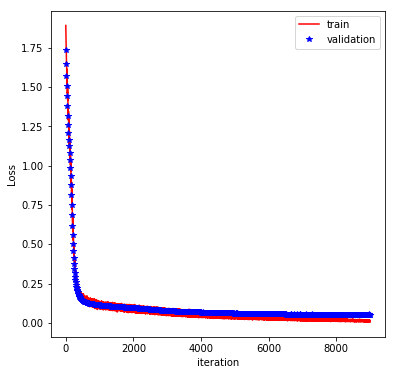

In [16]:
# Plot training and test loss
t = np.arange(iteration-1)

plt.figure(figsize = (6,6))
plt.plot(t, np.array(train_loss), 'r-', t[t % 10 == 0], np.array(validation_loss), 'b*')
plt.xlabel("iteration")
plt.ylabel("Loss")
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

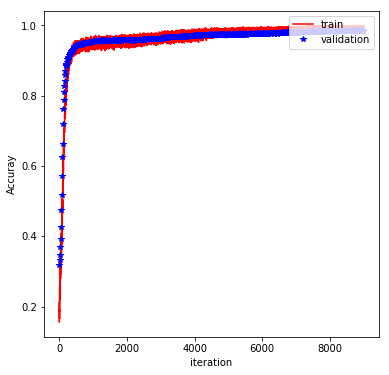

In [17]:
# Plot Accuracies
plt.figure(figsize = (6,6))

plt.plot(t, np.array(train_acc), 'r-', t[t % 10 == 0], validation_acc, 'b*')
plt.xlabel("iteration")
plt.ylabel("Accuray")
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

## Evaluate on test set

In [18]:
test_acc = []

with tf.Session(graph=graph) as sess:
    # Restore
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints-cnn'))
    
    for x_t, y_t in get_batches(X_test, y_test, batch_size):
        feed = {inputs_: x_t,
                labels_: y_t,
                keep_prob_: 1}
        
        batch_acc = sess.run(accuracy, feed_dict=feed)
        test_acc.append(batch_acc)
    print("Test accuracy: {:.6f}".format(np.mean(test_acc)))

INFO:tensorflow:Restoring parameters from checkpoints-cnn/har.ckpt


INFO:tensorflow:Restoring parameters from checkpoints-cnn/har.ckpt


Test accuracy: 0.925417
